In [1]:
import numpy as np
import pandas as pd
import math

# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
pd.options.display.float_format = '{:.2f}'.format
# pd.options.display.max_rows = None  # 모든 row 내용 print
pd.options.display.max_rows = 20

### Load the dataset with pandas
The car data set we will be using in this lab is provided as a comma separated file without a header row.  In order for each column to have a meaningful header name we must provide it.  We get the information about the columns from the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile).

We will use the features of the car, to try to predict its price.

In [3]:
# Provide the names for the columns since the CSV file with the data does not have a header row.
feature_names = ['symboling', 'normalized-losses', 'make', 'fuel-type',
        'aspiration', 'num-doors', 'body-style', 'drive-wheels',
        'engine-location', 'wheel-base', 'length', 'width', 'height', 'weight',
        'engine-type', 'num-cylinders', 'engine-size', 'fuel-system', 'bore',
        'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
        'highway-mpg', 'price']

In [4]:
# Load in the data from a CSV file that is comma separated.
car_data = pd.read_csv('https://storage.googleapis.com/mledu-datasets/cars_data.csv',
                     sep=',', names=feature_names, header=None, encoding='latin-1')

 We'll then randomize the data, just to be sure not to get any pathological ordering effects that might harm the performance of Stochastic Gradient Descent.

In [5]:
car_data = car_data.reindex(np.random.permutation(car_data.index))
# or equivalently,
# car_data = car_data.sample(frac=1)

In [6]:
print("Data set loaded. Num examples: ", len(car_data))

Data set loaded. Num examples:  205


In [7]:
car_data.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
197,-1,74,volvo,gas,std,four,wagon,rwd,front,104.30,...,141,mpfi,3.78,3.15,9.50,114,5400,24,28,16515
37,0,106,honda,gas,std,two,hatchback,fwd,front,96.50,...,110,1bbl,3.15,3.58,9.00,86,5800,27,33,7895
86,1,125,mitsubishi,gas,std,four,sedan,fwd,front,96.30,...,122,2bbl,3.35,3.46,8.50,88,5000,25,32,8189
187,2,94,volkswagen,diesel,turbo,four,sedan,fwd,front,97.30,...,97,idi,3.01,3.40,23.00,68,4500,37,42,9495
188,2,94,volkswagen,gas,std,four,sedan,fwd,front,97.30,...,109,mpfi,3.19,3.40,10.00,100,5500,26,32,9995


This is a really small dataset! Only 205 examples.

For simplicity in this codelab, we do not split the data further into training and validation. But you MUST do this on real datasets, or else you will overfit to your single dataset.

## Task 0: Use pandas to explore and prepare the data

- Use Pandas to inspect the data and manually curate a list of numeric_feature_names and categorical_feature_names.


Useful functions:
- `type()` called on any Python object describes the type of the object
- `dataframe[4:7]` pulls out rows 4, 5, 6 in a Pandas dataframe
- `dataframe[['mycol1', 'mycol2']]` pulls out the two requested columns into a new Pandas dataframe
- `dataframe['mycol1']` returns a Pandas series -- not a dataframe!
- `dataframe.describe()` prints out statistics for each dataframe column

In [8]:
car_data[4:7]

,symboling,normalized-losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
188,2,94,volkswagen,gas,std,four,sedan,fwd,front,97.30,...,109,mpfi,3.19,3.40,10.00,100,5500,26,32,9995
163,1,168,toyota,gas,std,two,sedan,rwd,front,94.50,...,98,2bbl,3.19,3.03,9.00,70,4800,29,34,8058
130,0,?,renault,gas,std,four,wagon,fwd,front,96.10,...,132,mpfi,3.46,3.90,8.70,?,?,23,31,9295


In [9]:
car_data.describe()

,symboling,wheel-base,length,width,height,weight,engine-size,compression-ratio,city-mpg,highway-mpg
count,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00
mean,0.83,98.76,174.05,65.91,53.72,2555.57,126.91,10.14,25.22,30.75
std,1.25,6.02,12.34,2.15,2.44,520.68,41.64,3.97,6.54,6.89
min,-2.00,86.60,141.10,60.30,47.80,1488.00,61.00,7.00,13.00,16.00
25%,0.00,94.50,166.30,64.10,52.00,2145.00,97.00,8.60,19.00,25.00
50%,1.00,97.00,173.20,65.50,54.10,2414.00,120.00,9.00,24.00,30.00
75%,2.00,102.40,183.10,66.90,55.50,2935.00,141.00,9.40,30.00,34.00
max,3.00,120.90,208.10,72.30,59.80,4066.00,326.00,23.00,49.00,54.00


In [10]:
LABEL = 'price'

numeric_feature_names = ['symboling', 'normalized-losses', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-size', 'horsepower',
        'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke',
         'compression-ratio']

categorical_feature_names = list(set(feature_names) - set(numeric_feature_names) - set([LABEL]))

categorical_feature_names

assert len(numeric_feature_names) == 15
assert len(categorical_feature_names) == 10

In [11]:
# The correct solution will pass these assert statements.
assert len(numeric_feature_names) == 15
assert len(categorical_feature_names) == 10

In [12]:
# Run to inspect numeric features.
car_data[numeric_feature_names]

,symboling,normalized-losses,wheel-base,length,width,height,weight,engine-size,horsepower,peak-rpm,city-mpg,highway-mpg,bore,stroke,compression-ratio
197,-1,74,104.30,188.80,67.20,57.50,3042,141,114,5400,24,28,3.78,3.15,9.50
37,0,106,96.50,167.50,65.20,53.30,2236,110,86,5800,27,33,3.15,3.58,9.00
86,1,125,96.30,172.40,65.40,51.60,2405,122,88,5000,25,32,3.35,3.46,8.50
187,2,94,97.30,171.70,65.50,55.70,2319,97,68,4500,37,42,3.01,3.40,23.00
188,2,94,97.30,171.70,65.50,55.70,2300,109,100,5500,26,32,3.19,3.40,10.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,2,134,98.40,176.20,65.60,52.00,2540,146,116,4800,24,30,3.62,3.50,9.30
157,0,91,95.70,166.30,64.40,52.80,2109,98,70,4800,30,37,3.19,3.03,9.00
191,0,?,100.40,180.20,66.90,55.10,2661,136,110,5500,19,24,3.19,3.40,8.50
68,-1,93,110.00,190.90,70.30,58.70,3750,183,123,4350,22,25,3.58,3.64,21.50


In [13]:
car_data[numeric_feature_names].describe()

,symboling,wheel-base,length,width,height,weight,engine-size,city-mpg,highway-mpg,compression-ratio
count,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00
mean,0.83,98.76,174.05,65.91,53.72,2555.57,126.91,25.22,30.75,10.14
std,1.25,6.02,12.34,2.15,2.44,520.68,41.64,6.54,6.89,3.97
min,-2.00,86.60,141.10,60.30,47.80,1488.00,61.00,13.00,16.00,7.00
25%,0.00,94.50,166.30,64.10,52.00,2145.00,97.00,19.00,25.00,8.60
50%,1.00,97.00,173.20,65.50,54.10,2414.00,120.00,24.00,30.00,9.00
75%,2.00,102.40,183.10,66.90,55.50,2935.00,141.00,30.00,34.00,9.40
max,3.00,120.90,208.10,72.30,59.80,4066.00,326.00,49.00,54.00,23.00


In [14]:
# Coerce the numeric features to numbers. This is necessary because the model crashes because not all the values are numeric.
for feature_name in numeric_feature_names + [LABEL]:
    car_data[feature_name] = pd.to_numeric(car_data[feature_name], errors ='coerce')

"""
errors: error는 총 3개의 옵션이 존재합니다.
- errors = 'ignore' -> 만약 숫자로 변경할 수 없는 데이터라면 숫자로 변경하지 않고 원본 데이터를 그대로 반환합니다.
- errors = 'coerce' -> 만약 숫자로 변경할 수 없는 데이터라면 기존 데이터를 지우고 NaN으로 설정하여 반환합니다.
- errors = 'raise' -> 만약 숫자로 변경할 수 없는 데이터라면 에러를 일으키며 코드를 중단합니다."""
    
# Fill missing values with 0.
# Is this an OK thing to do? You may want to come back and revisit this decision later.
car_data.fillna(0, inplace=True)

## Task 1: Make your best model with numeric features. No normalization allowed.

Modify the model provided below to achieve the lowest eval loss. You may want to change various hyperparameters:
- learning rate
- choice of optimizer
- hidden layer dimensions -- make sure your choice here makes sense given the number of training examples
- batch size
- num training steps
- (anything else you can think of changing)

Do not use the `normalizer_fn` arg on `numeric_column`.

In [15]:
car_data.shape

(205, 26)

In [16]:
X = car_data[numeric_feature_names].copy()
y = car_data['price'].copy()

In [17]:
X.columns

Index(['symboling', 'normalized-losses', 'wheel-base', 'length', 'width',
       'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg',
       'highway-mpg', 'bore', 'stroke', 'compression-ratio'],
      dtype='object')

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 )

In [19]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=3, input_shape=(15,), activation='relu'))
model.add(tf.keras.layers.Dense(units=1))
model.compile(tf.keras.optimizers.Adam(learning_rate=0.01),
             loss='mean_squared_error',
             metrics=[tf.keras.metrics.MeanSquaredError()])

In [20]:
batch_size=16
epochs=1000
model.fit(X_train, y_train, epochs=epochs, batch_size= batch_size)

Epoch 1/1000
11/11 [==============================] - 1s 2ms/step - loss: 229092272.0000 - mean_squared_error: 229092272.0000
Epoch 2/1000
11/11 [==============================] - 0s 3ms/step - loss: 214169120.0000 - mean_squared_error: 214169120.0000
Epoch 3/1000
11/11 [==============================] - 0s 2ms/step - loss: 195123152.0000 - mean_squared_error: 195123152.0000
Epoch 4/1000
11/11 [==============================] - 0s 3ms/step - loss: 170834592.0000 - mean_squared_error: 170834592.0000
Epoch 5/1000
11/11 [==============================] - 0s 2ms/step - loss: 143409344.0000 - mean_squared_error: 143409344.0000
Epoch 6/1000
11/11 [==============================] - 0s 2ms/step - loss: 116140360.0000 - mean_squared_error: 116140360.0000
Epoch 7/1000
11/11 [==============================] - 0s 2ms/step - loss: 94311408.0000 - mean_squared_error: 94311408.0000
Epoch 8/1000
11/11 [==============================] - 0s 2ms/step - loss: 78636816.0000 - mean_squared_error: 78636816.0

Epoch 66/1000
11/11 [==============================] - 0s 2ms/step - loss: 25570708.0000 - mean_squared_error: 25570708.0000
Epoch 67/1000
11/11 [==============================] - 0s 3ms/step - loss: 25781720.0000 - mean_squared_error: 25781720.0000
Epoch 68/1000
11/11 [==============================] - 0s 2ms/step - loss: 26037478.0000 - mean_squared_error: 26037478.0000
Epoch 69/1000
11/11 [==============================] - 0s 2ms/step - loss: 26128162.0000 - mean_squared_error: 26128162.0000
Epoch 70/1000
11/11 [==============================] - 0s 2ms/step - loss: 25491384.0000 - mean_squared_error: 25491384.0000
Epoch 71/1000
11/11 [==============================] - 0s 3ms/step - loss: 26021468.0000 - mean_squared_error: 26021468.0000
Epoch 72/1000
11/11 [==============================] - 0s 2ms/step - loss: 25150382.0000 - mean_squared_error: 25150382.0000
Epoch 73/1000
11/11 [==============================] - 0s 2ms/step - loss: 25808152.0000 - mean_squared_error: 25808152.0000


11/11 [==============================] - 0s 2ms/step - loss: 24078140.0000 - mean_squared_error: 24078140.0000
Epoch 130/1000
11/11 [==============================] - 0s 2ms/step - loss: 24254182.0000 - mean_squared_error: 24254182.0000
Epoch 131/1000
11/11 [==============================] - 0s 2ms/step - loss: 24644920.0000 - mean_squared_error: 24644920.0000
Epoch 132/1000
11/11 [==============================] - 0s 1ms/step - loss: 24186222.0000 - mean_squared_error: 24186222.0000
Epoch 133/1000
11/11 [==============================] - 0s 2ms/step - loss: 23965920.0000 - mean_squared_error: 23965920.0000
Epoch 134/1000
11/11 [==============================] - 0s 2ms/step - loss: 24209284.0000 - mean_squared_error: 24209284.0000
Epoch 135/1000
11/11 [==============================] - 0s 2ms/step - loss: 23792050.0000 - mean_squared_error: 23792050.0000
Epoch 136/1000
11/11 [==============================] - 0s 2ms/step - loss: 24124230.0000 - mean_squared_error: 24124230.0000
Epoch 1

11/11 [==============================] - 0s 2ms/step - loss: 22677134.0000 - mean_squared_error: 22677134.0000
Epoch 195/1000
11/11 [==============================] - 0s 2ms/step - loss: 23318880.0000 - mean_squared_error: 23318880.0000
Epoch 196/1000
11/11 [==============================] - 0s 2ms/step - loss: 22932962.0000 - mean_squared_error: 22932962.0000
Epoch 197/1000
11/11 [==============================] - 0s 2ms/step - loss: 22784418.0000 - mean_squared_error: 22784418.0000
Epoch 198/1000
11/11 [==============================] - 0s 2ms/step - loss: 22915772.0000 - mean_squared_error: 22915772.0000
Epoch 199/1000
11/11 [==============================] - 0s 2ms/step - loss: 23603118.0000 - mean_squared_error: 23603118.0000
Epoch 200/1000
11/11 [==============================] - 0s 2ms/step - loss: 23505118.0000 - mean_squared_error: 23505118.0000
Epoch 201/1000
11/11 [==============================] - 0s 2ms/step - loss: 22903600.0000 - mean_squared_error: 22903600.0000
Epoch 2

11/11 [==============================] - 0s 2ms/step - loss: 22216992.0000 - mean_squared_error: 22216992.0000
Epoch 259/1000
11/11 [==============================] - 0s 2ms/step - loss: 22188840.0000 - mean_squared_error: 22188840.0000
Epoch 260/1000
11/11 [==============================] - 0s 2ms/step - loss: 22449624.0000 - mean_squared_error: 22449624.0000
Epoch 261/1000
11/11 [==============================] - 0s 2ms/step - loss: 22336026.0000 - mean_squared_error: 22336026.0000
Epoch 262/1000
11/11 [==============================] - 0s 2ms/step - loss: 22316448.0000 - mean_squared_error: 22316448.0000
Epoch 263/1000
11/11 [==============================] - 0s 2ms/step - loss: 22434430.0000 - mean_squared_error: 22434430.0000
Epoch 264/1000
11/11 [==============================] - 0s 2ms/step - loss: 21831620.0000 - mean_squared_error: 21831620.0000
Epoch 265/1000
11/11 [==============================] - 0s 2ms/step - loss: 22237994.0000 - mean_squared_error: 22237994.0000
Epoch 2

11/11 [==============================] - 0s 2ms/step - loss: 21401624.0000 - mean_squared_error: 21401624.0000
Epoch 323/1000
11/11 [==============================] - 0s 2ms/step - loss: 21264840.0000 - mean_squared_error: 21264840.0000
Epoch 324/1000
11/11 [==============================] - 0s 2ms/step - loss: 21233416.0000 - mean_squared_error: 21233416.0000
Epoch 325/1000
11/11 [==============================] - 0s 2ms/step - loss: 21218944.0000 - mean_squared_error: 21218944.0000
Epoch 326/1000
11/11 [==============================] - 0s 2ms/step - loss: 21237144.0000 - mean_squared_error: 21237144.0000
Epoch 327/1000
11/11 [==============================] - 0s 3ms/step - loss: 21113374.0000 - mean_squared_error: 21113374.0000
Epoch 328/1000
11/11 [==============================] - 0s 3ms/step - loss: 21166150.0000 - mean_squared_error: 21166150.0000
Epoch 329/1000
11/11 [==============================] - 0s 3ms/step - loss: 21081952.0000 - mean_squared_error: 21081952.0000
Epoch 3

11/11 [==============================] - 0s 3ms/step - loss: 20652984.0000 - mean_squared_error: 20652984.0000
Epoch 388/1000
11/11 [==============================] - 0s 3ms/step - loss: 20675668.0000 - mean_squared_error: 20675668.0000
Epoch 389/1000
11/11 [==============================] - 0s 3ms/step - loss: 20841086.0000 - mean_squared_error: 20841086.0000
Epoch 390/1000
11/11 [==============================] - 0s 2ms/step - loss: 21117664.0000 - mean_squared_error: 21117664.0000
Epoch 391/1000
11/11 [==============================] - 0s 2ms/step - loss: 20701488.0000 - mean_squared_error: 20701488.0000
Epoch 392/1000
11/11 [==============================] - 0s 2ms/step - loss: 20657014.0000 - mean_squared_error: 20657014.0000
Epoch 393/1000
11/11 [==============================] - 0s 2ms/step - loss: 20734372.0000 - mean_squared_error: 20734372.0000
Epoch 394/1000
11/11 [==============================] - 0s 2ms/step - loss: 20731828.0000 - mean_squared_error: 20731828.0000
Epoch 3

11/11 [==============================] - 0s 2ms/step - loss: 20425896.0000 - mean_squared_error: 20425896.0000
Epoch 453/1000
11/11 [==============================] - 0s 2ms/step - loss: 20255968.0000 - mean_squared_error: 20255968.0000
Epoch 454/1000
11/11 [==============================] - 0s 2ms/step - loss: 20338462.0000 - mean_squared_error: 20338462.0000
Epoch 455/1000
11/11 [==============================] - 0s 2ms/step - loss: 20435232.0000 - mean_squared_error: 20435232.0000
Epoch 456/1000
11/11 [==============================] - 0s 3ms/step - loss: 20050444.0000 - mean_squared_error: 20050444.0000
Epoch 457/1000
11/11 [==============================] - 0s 3ms/step - loss: 20244548.0000 - mean_squared_error: 20244548.0000
Epoch 458/1000
11/11 [==============================] - 0s 3ms/step - loss: 20206674.0000 - mean_squared_error: 20206674.0000
Epoch 459/1000
11/11 [==============================] - 0s 3ms/step - loss: 20269166.0000 - mean_squared_error: 20269166.0000
Epoch 4

Epoch 516/1000
11/11 [==============================] - 0s 3ms/step - loss: 19986918.0000 - mean_squared_error: 19986918.0000
Epoch 517/1000
11/11 [==============================] - 0s 3ms/step - loss: 20258610.0000 - mean_squared_error: 20258610.0000
Epoch 518/1000
11/11 [==============================] - 0s 2ms/step - loss: 19978122.0000 - mean_squared_error: 19978122.0000
Epoch 519/1000
11/11 [==============================] - 0s 2ms/step - loss: 20178130.0000 - mean_squared_error: 20178130.0000
Epoch 520/1000
11/11 [==============================] - 0s 2ms/step - loss: 20245244.0000 - mean_squared_error: 20245244.0000
Epoch 521/1000
11/11 [==============================] - 0s 2ms/step - loss: 19912152.0000 - mean_squared_error: 19912152.0000
Epoch 522/1000
11/11 [==============================] - 0s 2ms/step - loss: 20585986.0000 - mean_squared_error: 20585986.0000
Epoch 523/1000
11/11 [==============================] - 0s 2ms/step - loss: 20120590.0000 - mean_squared_error: 201205

11/11 [==============================] - 0s 5ms/step - loss: 19579222.0000 - mean_squared_error: 19579222.0000
Epoch 581/1000
11/11 [==============================] - 0s 3ms/step - loss: 19741696.0000 - mean_squared_error: 19741696.0000
Epoch 582/1000
11/11 [==============================] - 0s 2ms/step - loss: 20281292.0000 - mean_squared_error: 20281292.0000
Epoch 583/1000
11/11 [==============================] - 0s 2ms/step - loss: 19645564.0000 - mean_squared_error: 19645564.0000
Epoch 584/1000
11/11 [==============================] - 0s 2ms/step - loss: 20019492.0000 - mean_squared_error: 20019492.0000
Epoch 585/1000
11/11 [==============================] - 0s 3ms/step - loss: 19926078.0000 - mean_squared_error: 19926078.0000
Epoch 586/1000
11/11 [==============================] - 0s 2ms/step - loss: 19715814.0000 - mean_squared_error: 19715814.0000
Epoch 587/1000
11/11 [==============================] - 0s 2ms/step - loss: 19512914.0000 - mean_squared_error: 19512914.0000
Epoch 5

11/11 [==============================] - 0s 3ms/step - loss: 19385796.0000 - mean_squared_error: 19385796.0000
Epoch 645/1000
11/11 [==============================] - 0s 4ms/step - loss: 19237944.0000 - mean_squared_error: 19237944.0000
Epoch 646/1000
11/11 [==============================] - 0s 4ms/step - loss: 19341814.0000 - mean_squared_error: 19341814.0000
Epoch 647/1000
11/11 [==============================] - 0s 4ms/step - loss: 19230342.0000 - mean_squared_error: 19230342.0000
Epoch 648/1000
11/11 [==============================] - ETA: 0s - loss: 12102885.0000 - mean_squared_error: 12102885.00 - 0s 2ms/step - loss: 19712068.0000 - mean_squared_error: 19712068.0000
Epoch 649/1000
11/11 [==============================] - 0s 3ms/step - loss: 19202910.0000 - mean_squared_error: 19202910.0000
Epoch 650/1000
11/11 [==============================] - 0s 2ms/step - loss: 19304664.0000 - mean_squared_error: 19304664.0000
Epoch 651/1000
11/11 [==============================] - 0s 2ms/step

11/11 [==============================] - 0s 2ms/step - loss: 19372398.0000 - mean_squared_error: 19372398.0000
Epoch 709/1000
11/11 [==============================] - 0s 2ms/step - loss: 19150362.0000 - mean_squared_error: 19150362.0000
Epoch 710/1000
11/11 [==============================] - 0s 3ms/step - loss: 18892004.0000 - mean_squared_error: 18892004.0000
Epoch 711/1000
11/11 [==============================] - 0s 3ms/step - loss: 20095704.0000 - mean_squared_error: 20095704.0000
Epoch 712/1000
11/11 [==============================] - 0s 2ms/step - loss: 19748896.0000 - mean_squared_error: 19748896.0000
Epoch 713/1000
11/11 [==============================] - 0s 2ms/step - loss: 20090780.0000 - mean_squared_error: 20090780.0000
Epoch 714/1000
11/11 [==============================] - 0s 2ms/step - loss: 19267864.0000 - mean_squared_error: 19267864.0000
Epoch 715/1000
11/11 [==============================] - 0s 2ms/step - loss: 20000466.0000 - mean_squared_error: 20000466.0000
Epoch 7

11/11 [==============================] - 0s 2ms/step - loss: 18784886.0000 - mean_squared_error: 18784886.0000
Epoch 774/1000
11/11 [==============================] - 0s 2ms/step - loss: 19078618.0000 - mean_squared_error: 19078618.0000
Epoch 775/1000
11/11 [==============================] - 0s 2ms/step - loss: 18431640.0000 - mean_squared_error: 18431640.0000
Epoch 776/1000
11/11 [==============================] - 0s 2ms/step - loss: 18743120.0000 - mean_squared_error: 18743120.0000
Epoch 777/1000
11/11 [==============================] - 0s 2ms/step - loss: 18645916.0000 - mean_squared_error: 18645916.0000
Epoch 778/1000
11/11 [==============================] - 0s 2ms/step - loss: 19355162.0000 - mean_squared_error: 19355162.0000
Epoch 779/1000
11/11 [==============================] - 0s 2ms/step - loss: 18742168.0000 - mean_squared_error: 18742168.0000
Epoch 780/1000
11/11 [==============================] - 0s 2ms/step - loss: 18659646.0000 - mean_squared_error: 18659646.0000
Epoch 7

11/11 [==============================] - 0s 2ms/step - loss: 18717344.0000 - mean_squared_error: 18717344.0000
Epoch 839/1000
11/11 [==============================] - 0s 2ms/step - loss: 20808078.0000 - mean_squared_error: 20808078.0000
Epoch 840/1000
11/11 [==============================] - 0s 2ms/step - loss: 19706002.0000 - mean_squared_error: 19706002.0000
Epoch 841/1000
11/11 [==============================] - 0s 2ms/step - loss: 18593554.0000 - mean_squared_error: 18593554.0000
Epoch 842/1000
11/11 [==============================] - 0s 2ms/step - loss: 18530578.0000 - mean_squared_error: 18530578.0000
Epoch 843/1000
11/11 [==============================] - 0s 3ms/step - loss: 18503736.0000 - mean_squared_error: 18503736.0000
Epoch 844/1000
11/11 [==============================] - 0s 2ms/step - loss: 18442100.0000 - mean_squared_error: 18442100.0000
Epoch 845/1000
11/11 [==============================] - 0s 3ms/step - loss: 18789706.0000 - mean_squared_error: 18789706.0000
Epoch 8

11/11 [==============================] - 0s 2ms/step - loss: 17708566.0000 - mean_squared_error: 17708566.0000
Epoch 904/1000
11/11 [==============================] - 0s 3ms/step - loss: 19755036.0000 - mean_squared_error: 19755036.0000
Epoch 905/1000
11/11 [==============================] - 0s 3ms/step - loss: 18636356.0000 - mean_squared_error: 18636356.0000
Epoch 906/1000
11/11 [==============================] - 0s 3ms/step - loss: 17830020.0000 - mean_squared_error: 17830020.0000
Epoch 907/1000
11/11 [==============================] - 0s 3ms/step - loss: 18079634.0000 - mean_squared_error: 18079634.0000
Epoch 908/1000
11/11 [==============================] - 0s 2ms/step - loss: 17896620.0000 - mean_squared_error: 17896620.0000
Epoch 909/1000
11/11 [==============================] - 0s 3ms/step - loss: 17827610.0000 - mean_squared_error: 17827610.0000
Epoch 910/1000
11/11 [==============================] - 0s 2ms/step - loss: 18431272.0000 - mean_squared_error: 18431272.0000
Epoch 9

11/11 [==============================] - 0s 2ms/step - loss: 17547566.0000 - mean_squared_error: 17547566.0000
Epoch 969/1000
11/11 [==============================] - 0s 3ms/step - loss: 17634066.0000 - mean_squared_error: 17634066.0000
Epoch 970/1000
11/11 [==============================] - 0s 3ms/step - loss: 17725188.0000 - mean_squared_error: 17725188.0000
Epoch 971/1000
11/11 [==============================] - 0s 2ms/step - loss: 17509406.0000 - mean_squared_error: 17509406.0000
Epoch 972/1000
11/11 [==============================] - 0s 2ms/step - loss: 17890266.0000 - mean_squared_error: 17890266.0000
Epoch 973/1000
11/11 [==============================] - 0s 2ms/step - loss: 17644728.0000 - mean_squared_error: 17644728.0000
Epoch 974/1000
11/11 [==============================] - 0s 2ms/step - loss: 17585448.0000 - mean_squared_error: 17585448.0000
Epoch 975/1000
11/11 [==============================] - 0s 2ms/step - loss: 17406418.0000 - mean_squared_error: 17406418.0000
Epoch 9

In [21]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 4ms/step - loss: 12075026.0000 - mean_squared_error: 12075026.0000


[12075026.0, 12075026.0]

### Visualize your model's predictions

After you have a trained model, it may be helpful to understand how your model's inference differs from the actual data.

This helper function `scatter_plot_inference` does that for you. Real data is in grey. Your model's predictions are in orange.


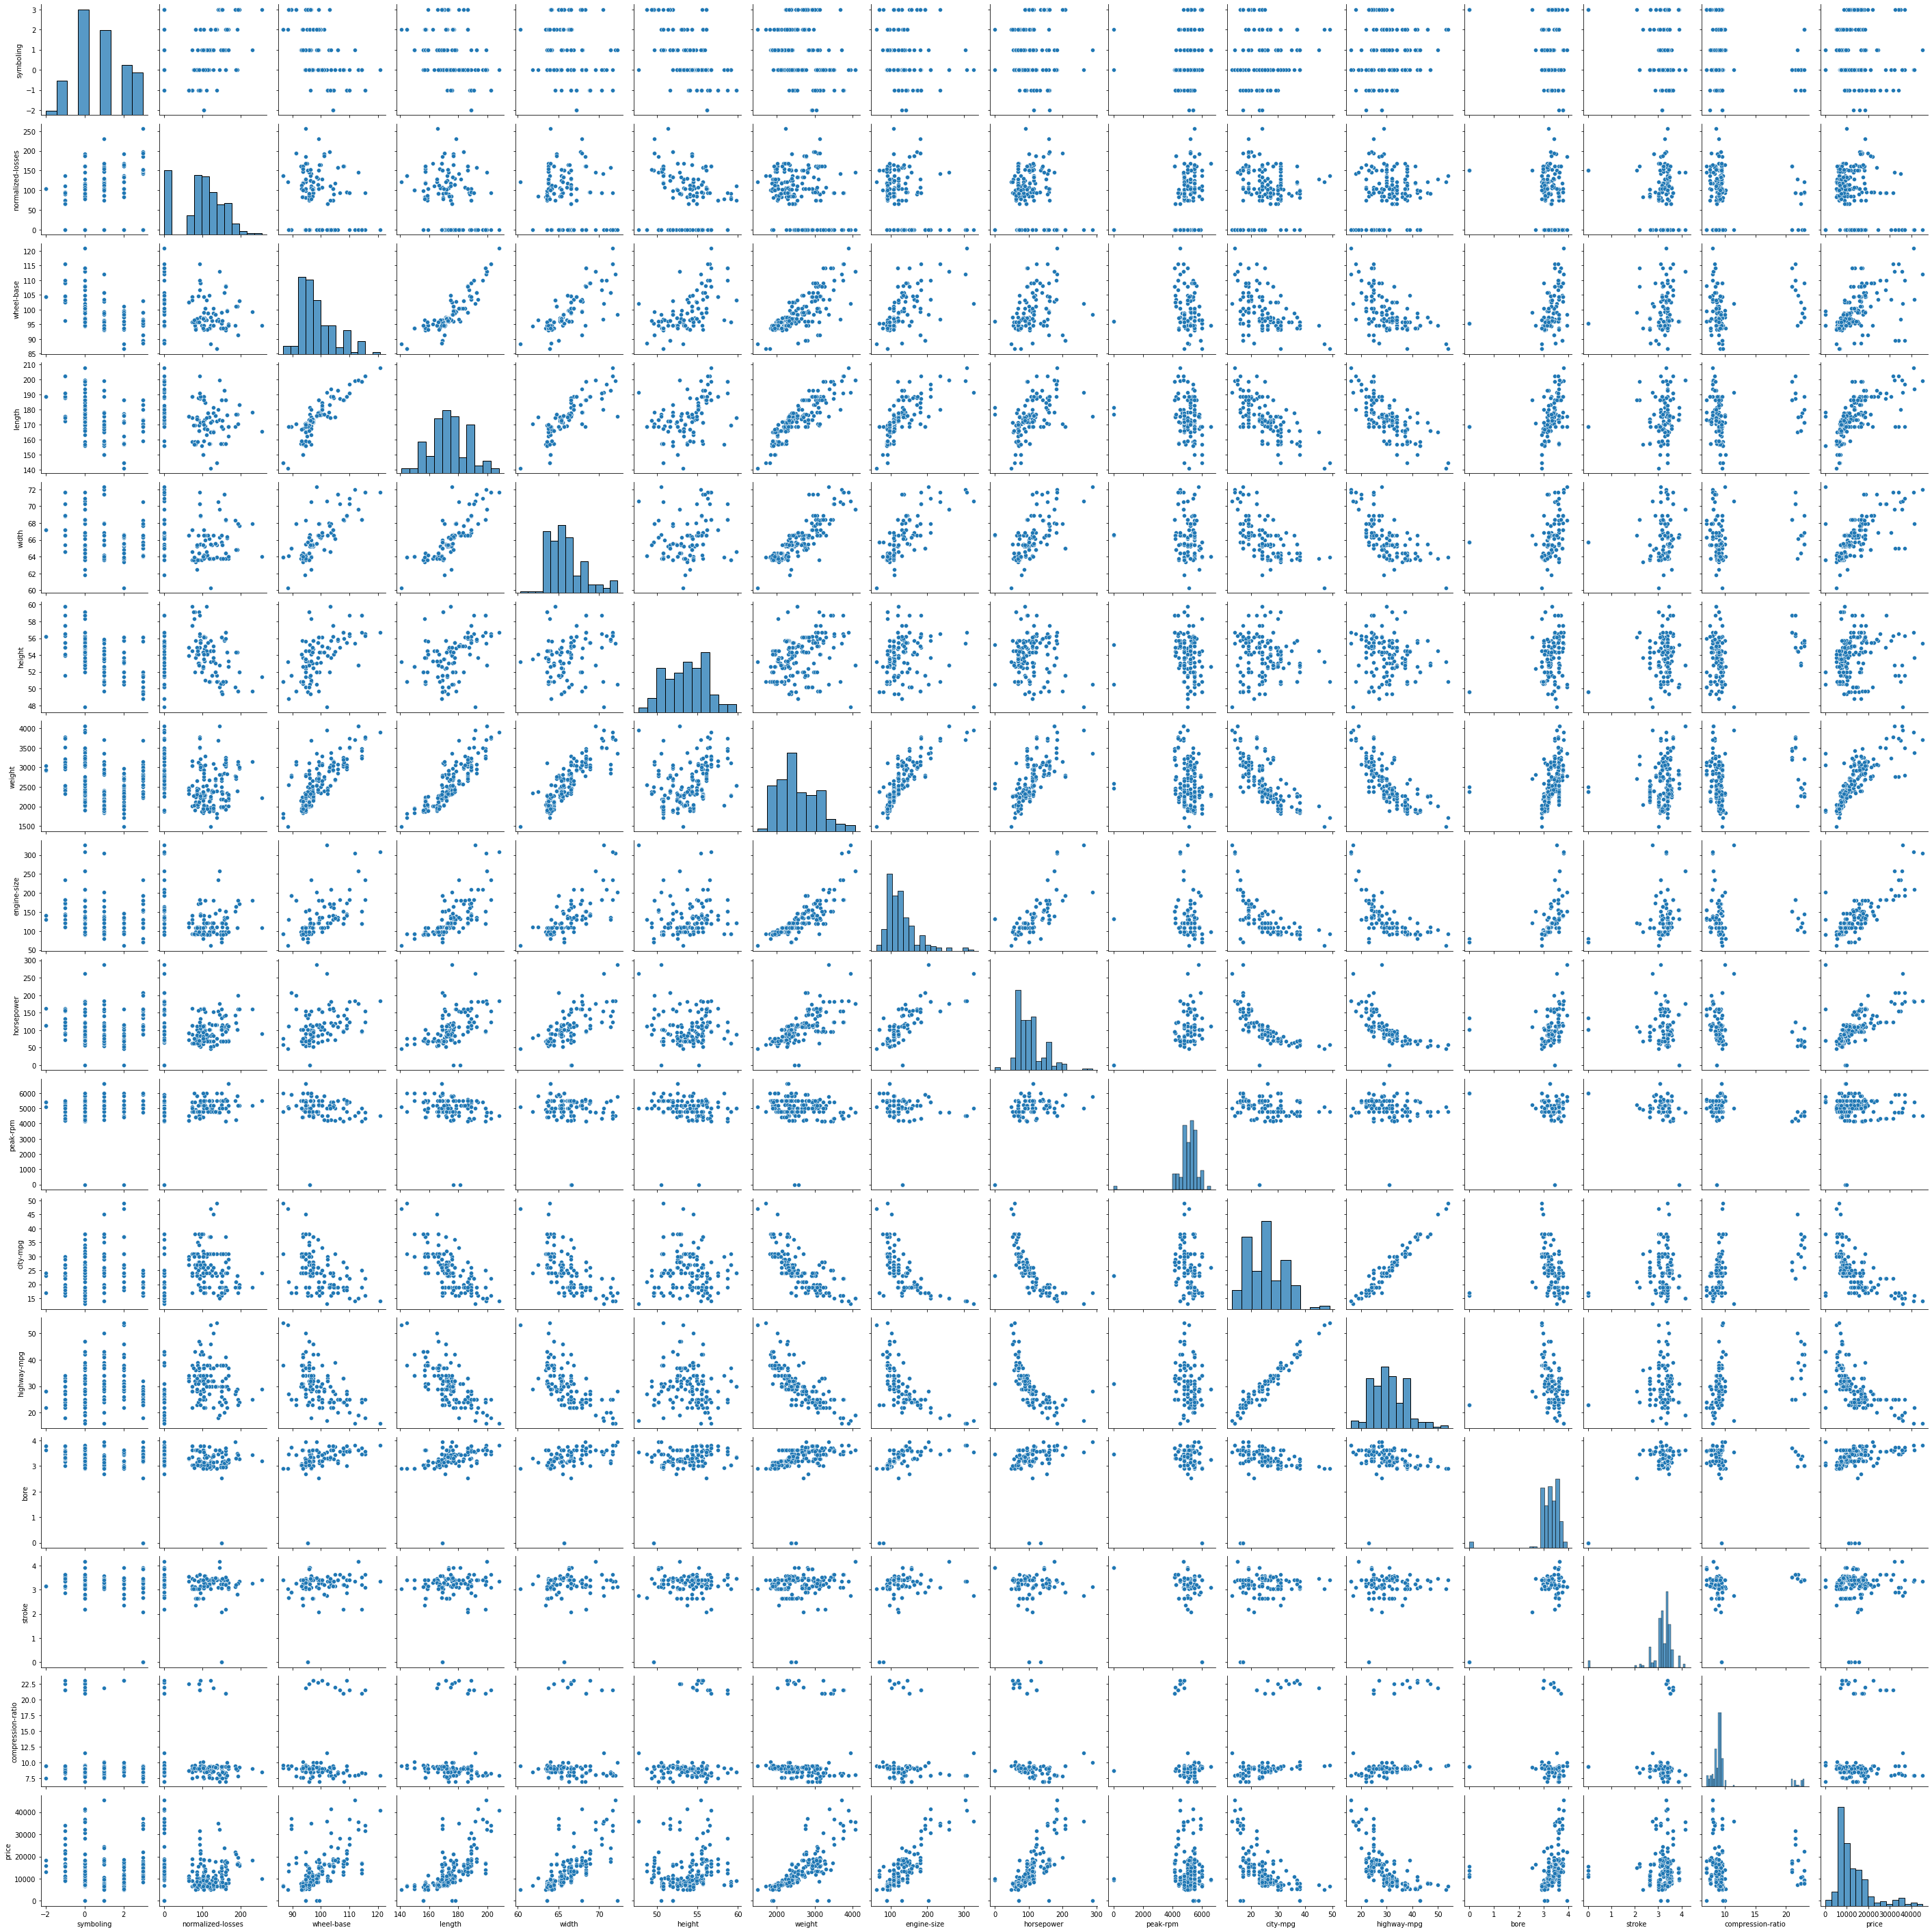

In [22]:
feature_list = ['symboling', 'normalized-losses', 'wheel-base', 'length', 'width',
       'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg',
       'highway-mpg', 'bore', 'stroke', 'compression-ratio', 'price']
sns.pairplot(car_data[feature_list], markers=["o", "s", "D"])

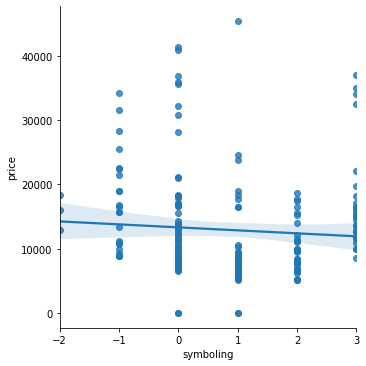

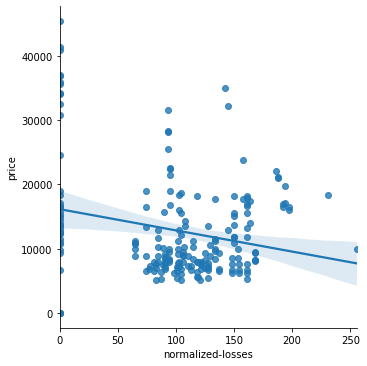

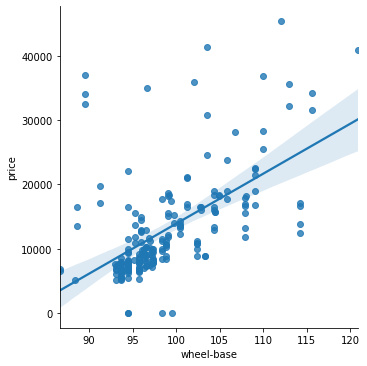

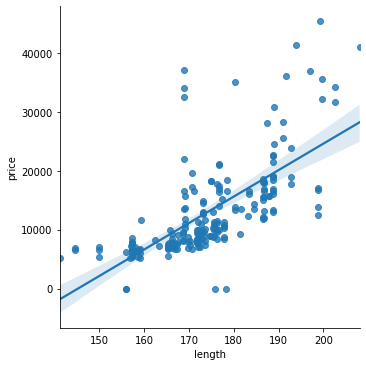

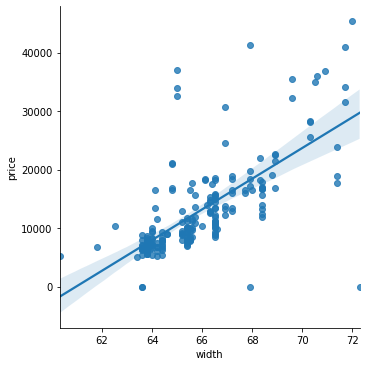

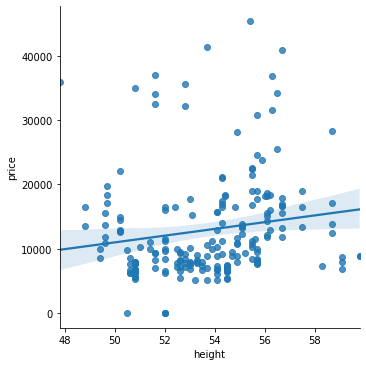

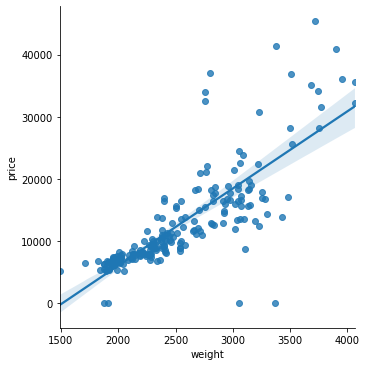

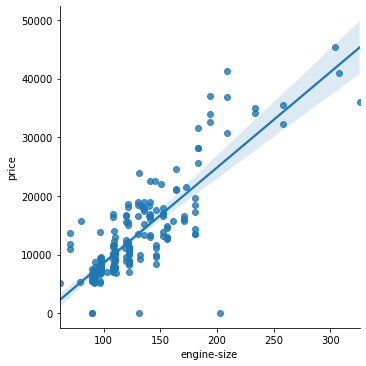

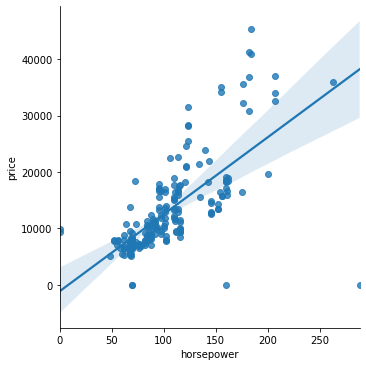

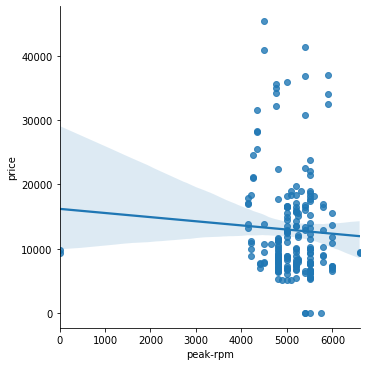

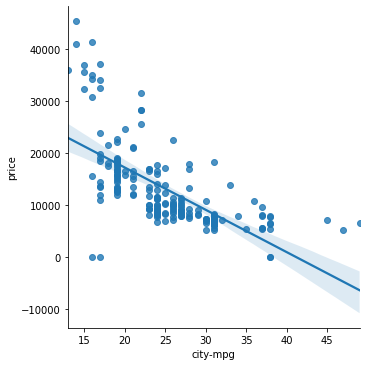

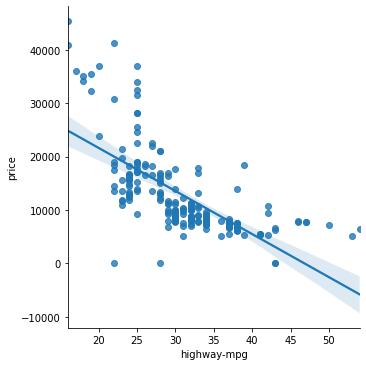

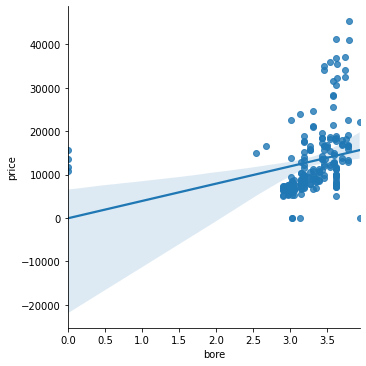

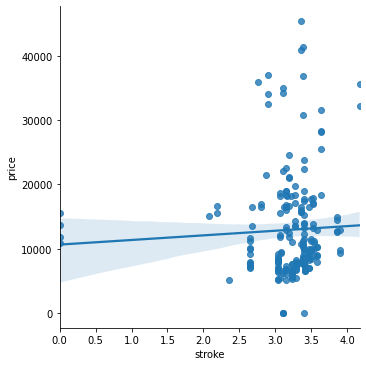

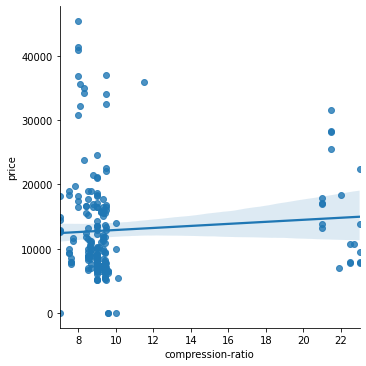

In [23]:
for n in feature_list[:-1]:
    sns.lmplot(x = n, y = 'price', data = car_data[feature_list])
    plt.show()

In [24]:
X1 = car_data[numeric_feature_names].iloc[0:1]
X1

,symboling,normalized-losses,wheel-base,length,width,height,weight,engine-size,horsepower,peak-rpm,city-mpg,highway-mpg,bore,stroke,compression-ratio
197,-1,74.00,104.30,188.80,67.20,57.50,3042,141,114.00,5400.00,24,28,3.78,3.15,9.50


In [25]:
y.iloc[0]

16515.0

In [26]:
X.head(2)

,symboling,normalized-losses,wheel-base,length,width,height,weight,engine-size,horsepower,peak-rpm,city-mpg,highway-mpg,bore,stroke,compression-ratio
197,-1,74.00,104.30,188.80,67.20,57.50,3042,141,114.00,5400.00,24,28,3.78,3.15,9.50
37,0,106.00,96.50,167.50,65.20,53.30,2236,110,86.00,5800.00,27,33,3.15,3.58,9.00


In [27]:
model.predict(X1)

array([[16174.432]], dtype=float32)

In [28]:
model.predict(X1).item()

16174.431640625

In [29]:
car_data['price']

197   16515.00
37     7895.00
86     8189.00
187    9495.00
188    9995.00
        ...   
167    8449.00
157    7198.00
191   13295.00
68    28248.00
33     6529.00
Name: price, Length: 205, dtype: float64

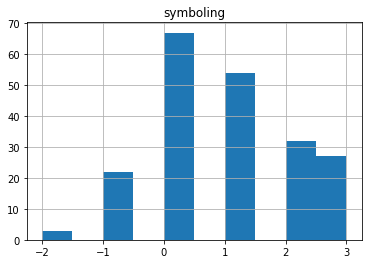

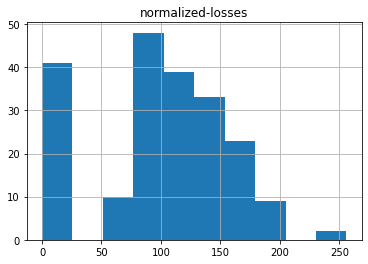

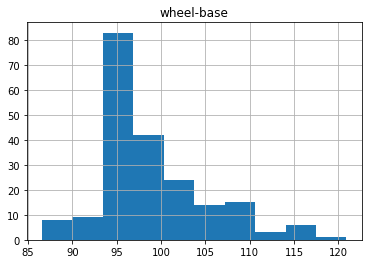

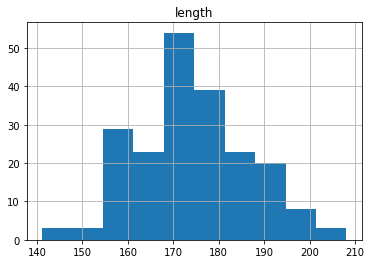

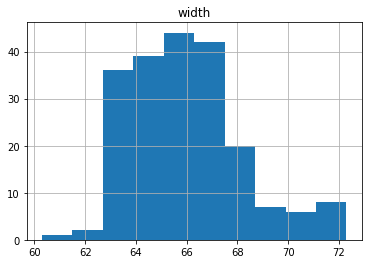

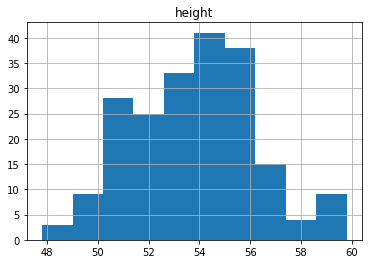

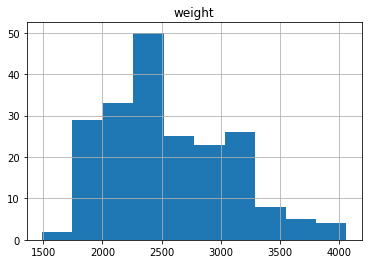

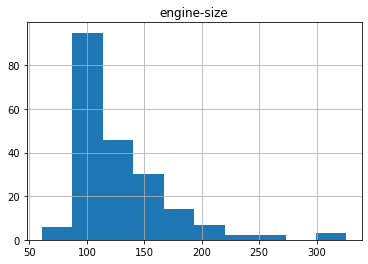

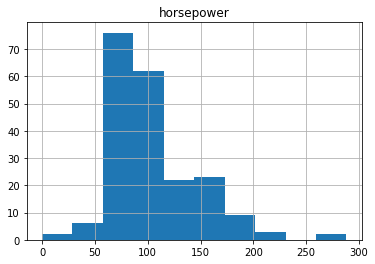

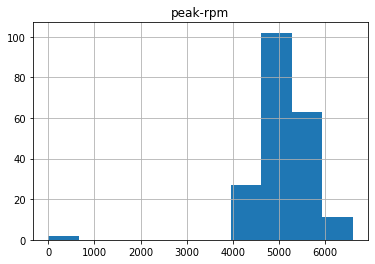

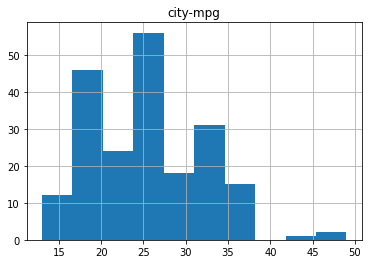

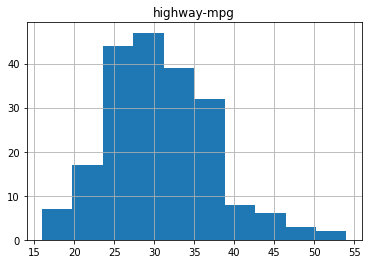

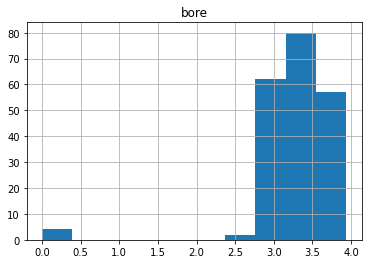

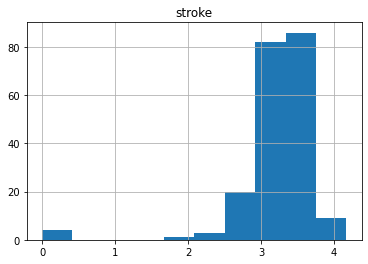

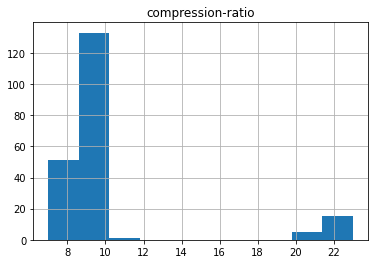

In [30]:
# This 1D visualization of each numeric feature might inform your normalization
# decisions.
for feature_name in numeric_feature_names:
  car_data.hist(column=feature_name)